##### import libaries 

In [0]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import mlflow
mlflow.pyspark.ml.autolog()
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.sql import *
from pyspark.sql.functions import*

In [0]:
# read dataset into spark DataFrame
StreamDf = spark.read.csv("/FileStore/tables/steam_200k__1_.csv", inferSchema=True, header=False).toDF("UserID", "Games", "Behavior", "Hours_Played")
StreamDf.display(10)

UserID Games Behavior Hours_Played 151603712 The Elder Scrolls V Skyrim purchase 1.0 151603712 The Elder Scrolls V Skyrim play 273.0 151603712 Fallout 4 purchase 1.0 151603712 Fallout 4 play 87.0 151603712 Spore purchase 1.0 151603712 Spore play 14.9 151603712 Fallout New Vegas purchase 1.0 151603712 Fallout New Vegas play 12.1 151603712 Left 4 Dead 2 purchase 1.0 151603712 Left 4 Dead 2 play 8.9 151603712 HuniePop purchase 1.0 151603712 HuniePop play 8.5 151603712 Path of Exile purchase 1.0 151603712 Path of Exile play 8.1 151603712 Poly Bridge purchase 1.0 151603712 Poly Bridge play 7.5 151603712 Left 4 Dead purchase 1.0 151603712 Left 4 Dead play 3.3 151603712 Team Fortress 2 purchase 1.0 151603712 Team Fortress 2 play 2.8 151603712 Tomb Raider purchase 1.0 151603712 Tomb Raider play 2.5 151603712 The Banner Saga purchase 1.0 151603712 The Banner Saga play 2.0 151603712 Dead Island Epidemic purchase 1.0 151603712 Dead Island Epidemic play 1.4 151603712 BioShock Infinite purchase 1.0 151603712 BioShock Infinite play 1.3 151603712 Dragon Age Origins - Ultimate Edition purchase 1.0 151603712 Dragon Age Origins - Ultimate Edition play 1.3 151603712 Fallout 3 - Game of the Year Edition purchase 1.0 151603712 Fallout 3 - Game of the Year Edition play 0.8 151603712 SEGA Genesis & Mega Drive Classics purchase 1.0 151603712 SEGA Genesis & Mega Drive Classics play 0.8 151603712 Grand Theft Auto IV purchase 1.0 151603712 Grand Theft Auto IV play 0.6 151603712 Realm of the Mad God purchase 1.0 151603712 Realm of the Mad God play 0.5 151603712 Marvel Heroes 2015 purchase 1.0 151603712 Marvel Heroes 2015 play 0.5 151603712 Eldevin purchase 1.0 151603712 Eldevin play 0.5 151603712 Dota 2 purchase 1.0 151603712 Dota 2 play 0.5 151603712 BioShock purchase 1.0 151603712 BioShock play 0.5 151603712 Robocraft purchase 1.0 151603712 Robocraft play 0.4 151603712 Garry's Mod purchase 1.0 151603712 Garry's Mod play 0.1 151603712 Jazzpunk purchase 1.0 151603712 Jazzpunk play 0.1 151603712 Alan Wake purchase 1.0 151603712 BioShock 2 purchase 1.0 151603712 Fallen Earth purchase 1.0 151603712 Fallout New Vegas Courier's Stash purchase 1.0 151603712 Fallout New Vegas Dead Money purchase 1.0 151603712 Fallout New Vegas Honest Hearts purchase 1.0 151603712 Grand Theft Auto Episodes from Liberty City purchase 1.0 151603712 Hitman Absolution purchase 1.0 151603712 HuniePop Official Digital Art Collection purchase 1.0 151603712 HuniePop Original Soundtrack purchase 1.0 151603712 The Banner Saga - Mod Content purchase 1.0 151603712 The Elder Scrolls V Skyrim - Dawnguard purchase 1.0 151603712 The Elder Scrolls V Skyrim - Dragonborn purchase 1.0 151603712 The Elder Scrolls V Skyrim - Hearthfire purchase 1.0 187131847 Dota 2 purchase 1.0 187131847 Dota 2 play 2.3 59945701 Ultra Street Fighter IV purchase 1.0 59945701 Ultra Street Fighter IV play 238.0 59945701 FINAL FANTASY XIII purchase 1.0 59945701 FINAL FANTASY XIII play 84.0 59945701 The Elder Scrolls V Skyrim purchase 1.0 59945701 The Elder Scrolls V Skyrim play 58.0 59945701 Sid Meier's Civilization V purchase 1.0 59945701 Sid Meier's Civilization V play 22.0 59945701 L.A. Noire purchase 1.0 59945701 L.A. Noire play 13.8 59945701 Company of Heroes Tales of Valor purchase 1.0 59945701 Company of Heroes Tales of Valor play 10.2 59945701 7 Days to Die purchase 1.0 59945701 7 Days to Die play 7.8 59945701 Divekick purchase 1.0 59945701 Divekick play 7.0 59945701 FINAL FANTASY VII purchase 1.0 59945701 FINAL FANTASY VII play 5.2 59945701 Orcs Must Die! 2 purchase 1.0 59945701 Orcs Must Die! 2 play 4.8 59945701 Killing Floor purchase 1.0 59945701 Killing Floor play 3.4 59945701 Company of Heroes purchase 1.0 59945701 Company of Heroes play 3.2 59945701 Bastion purchase 1.0 59945701 Bastion play 2.8 59945701 Undertale purchase 1.0 59945701 Undertale play 2.6 59945701 Counter-Strike Global Offensive purchase 1.0 59945701 Counter-Strike Global Offensive play 2.3 59945701 Orcs Must Die! purchase 1.0 59945701 Orcs 

####  DATA CLEANING AND EXPLORATION 

In [0]:


null_counts = {col_name: StreamDf.where(col(col_name).isNull()).count() for col_name in StreamDf.columns}
for col_name, count in null_counts.items():
    print(f"Column '{col_name}': {count} null values")


Column 'UserID': 0 null values
Column 'Games': 0 null values
Column 'Behavior': 0 null values
Column 'Hours_Played': 0 null values


In [0]:
StreamDf.describe().show()

+-------+-------------------+----------------+--------+------------------+
|summary|             UserID|           Games|Behavior|      Hours_Played|
+-------+-------------------+----------------+--------+------------------+
|  count|             200000|          200000|  200000|            200000|
|   mean|  1.0365586594664E8|           140.0|    NULL|17.874383999999914|
| stddev|7.208073512913968E7|             0.0|    NULL|138.05695165086792|
|    min|               5250|     007 Legends|    play|               0.1|
|    max|          309903146|theHunter Primal|purchase|           11754.0|
+-------+-------------------+----------------+--------+------------------+



In [0]:
StreamDf.dropna()

DataFrame[UserID: int, Games: string, Behavior: string, Hours_Played: double]

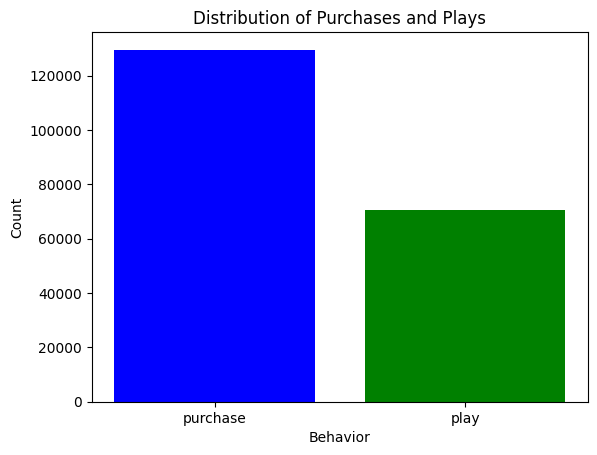

In [0]:


behavior_counts = StreamDf.groupBy("Behavior").count().collect()

behaviors = [row["Behavior"] for row in behavior_counts]
counts = [row["count"] for row in behavior_counts]
colors = ["blue", "green"]

# Plot the distribution
plt.bar(behaviors, counts , color =colors )
plt.xlabel("Behavior")
plt.ylabel("Count")
plt.title("Distribution of Purchases and Plays")
plt.show()


In [0]:
# Group by game name and compute total playtime and purchases
game_stats = StreamDf.groupBy("Games").agg({"Hours_played": "sum", "Behavior": "count"}).\
    withColumnRenamed("sum(hours_played)", "total_playtime").\
    withColumnRenamed("count(purchase)", "total_purchases")

# Sort games by total playtime or total purchases
popular_games = game_stats.orderBy("total_playtime", ascending=False).limit(10)
popular_games.display()


Games count(Behavior) total_playtime Dota 2 9682 986525.6 Counter-Strike Global Offensive 2789 324183.6000000001 Team Fortress 2 4646 175996.30000000008 Counter-Strike 1424 135117.09999999998 Sid Meier's Civilization V 1150 100417.30000000002 Counter-Strike Source 1693 97053.50000000003 The Elder Scrolls V Skyrim 1394 71606.3 Garry's Mod 1397 50456.30000000002 Call of Duty Modern Warfare 2 - Multiplayer 634 42352.899999999994 Left 4 Dead 2 1752 34547.7

#### Display the rate of play for each Game 

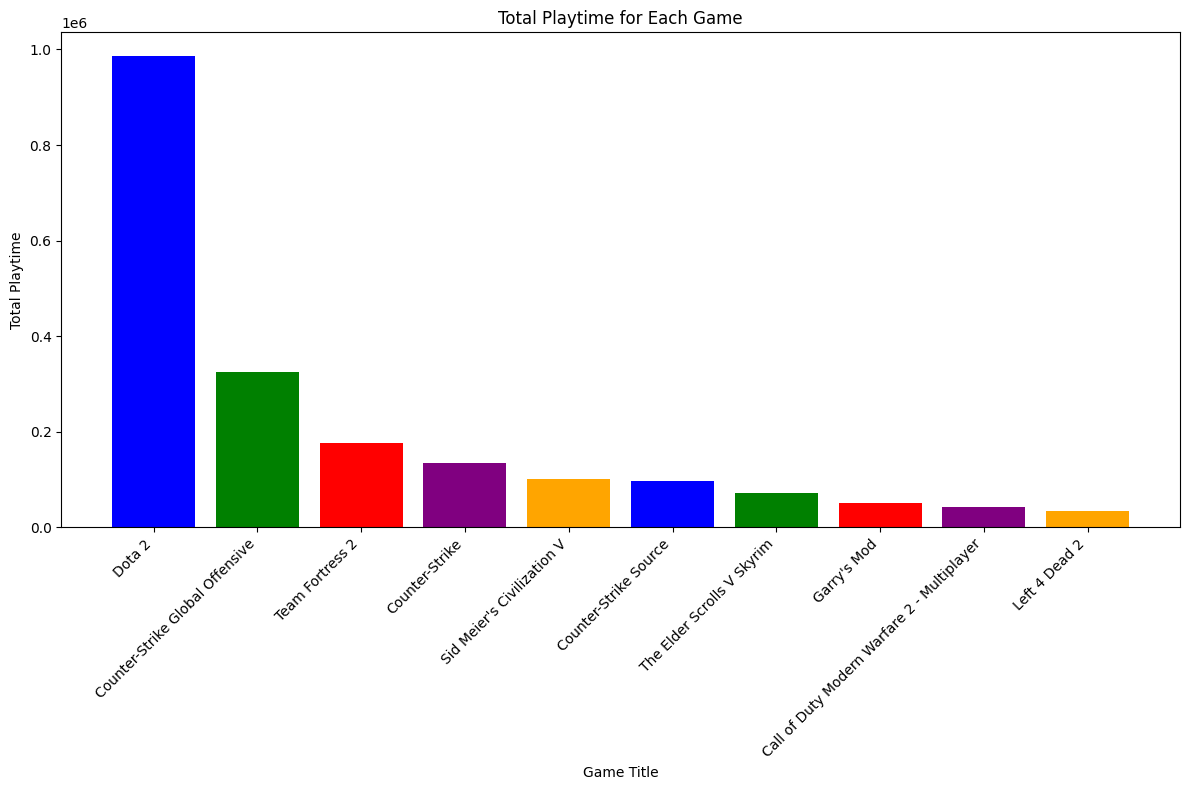

In [0]:

game_titles = [row["Games"] for row in popular_games.collect()]
total_playtime = [row["total_playtime"] for row in popular_games.collect()]
colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.figure(figsize=(12, 8))
plt.bar(game_titles, total_playtime, color= colors)
plt.xlabel('Game Title')
plt.ylabel('Total Playtime')
plt.title('Total Playtime for Each Game')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()  
plt.show()


In [0]:
ratings = StreamDf.select('Hours_played').toPandas()['Hours_played']
print(ratings)

0           1.0
1         273.0
2           1.0
3          87.0
4           1.0
          ...  
199995      1.5
199996      1.0
199997      1.5
199998      1.0
199999      1.4
Name: Hours_played, Length: 200000, dtype: float64


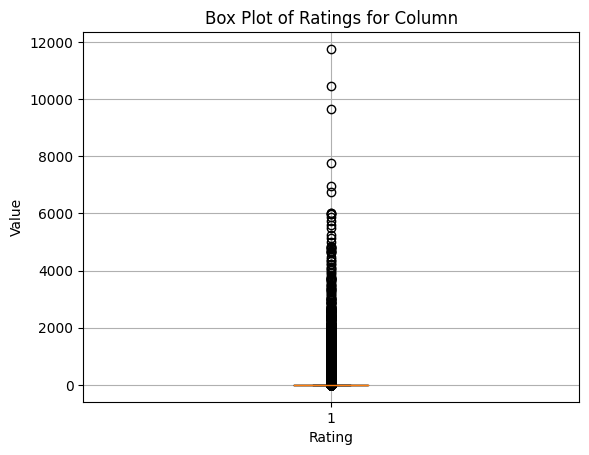

In [0]:

plt.boxplot(ratings)
plt.xlabel('Rating')
plt.ylabel('Value')
plt.grid('true')
plt.title('Box Plot of Ratings for Column')
plt.show()


In [0]:
rate = StreamDf.select('Hours_played').toPandas()['Hours_played']

plt.hist(rate,bins = 100,range =(0,100))
plt.xlabel('Rating')
plt.ylabel('Value')
plt.grid('true')
plt.title('hist Plot of Ratings ')
plt.show()

In [0]:
duplicate_count = StreamDf.count() - StreamDf.dropDuplicates().count()
 

display(spark.createDataFrame([(duplicate_count,)], ["Duplicate Rows"]))

Duplicate Rows 707

In [0]:
StreamDf = StreamDf.dropDuplicates()

In [0]:
duplicate_count = StreamDf.count() - StreamDf.dropDuplicates().count()
 
# Display the result
display(spark.createDataFrame([(duplicate_count,)], ["Duplicate Rows"]))

Duplicate Rows 0

#####  DATA PREPROCESSING  

In [0]:
from pyspark.sql.functions import col, monotonically_increasing_id

distinct_games_df = StreamDf.select("Games").distinct()
distinct_games_df = distinct_games_df.withColumn("game_ID", monotonically_increasing_id())
StreamDf = StreamDf.join(distinct_games_df, on="Games", how="inner")

StreamDf.display(5)


Games UserID Behavior Hours_Played game_ID The Talos Principle 53875128 play 9.8 412 Nidhogg 53875128 purchase 1.0 1967 INK 53875128 purchase 1.0 536 Sonic Generations 53875128 play 0.1 1499 Far Cry 3 126340495 purchase 1.0 4118 Cogs 97298878 purchase 1.0 1591 My Lands 226212066 purchase 1.0 1897 Amnesia The Dark Descent 65117175 play 3.3 997 Dead Bits 65117175 purchase 1.0 2134 Tales of Monkey Island Chapter 2 - The Siege of Spinner Cay 11373749 play 7.0 1997 Dungeon Defenders 11373749 play 2.3 2686 Dota 2 11373749 purchase 1.0 0 Counter-Strike Source 11373749 purchase 1.0 44 Arma 2 DayZ Mod 171847029 purchase 1.0 3172 Trine 2 56038151 play 2.8 1129 Batman Arkham City GOTY 56038151 purchase 1.0 290 EverQuest II 248444377 purchase 1.0 3872 EVGA PrecisionX 16 248444377 purchase 1.0 1530 War Thunder 100519466 play 1.6 4029 Pid 100519466 purchase 1.0 467 Counter-Strike Condition Zero 16167221 play 722.0 3605 Warhammer 40,000 Dawn of War II Retribution 41883322 purchase 1.0 4095 Dota 2 210669058 play 1.4 0 Dota 2 229467150 play 24.0 0 Call of Duty Black Ops - Multiplayer 75228114 play 201.0 2307 Arma 3 Zeus 136021775 purchase 1.0 3943 Day of Defeat Source 29835809 purchase 1.0 1616 Hitman 2 Silent Assassin 25096601 purchase 1.0 2334 Nancy Drew Tomb of the Lost Queen 111316830 play 6.0 1187 The Ball 92914917 purchase 1.0 629 Napoleon Total War 77870593 play 128.0 1387 Ticket to Ride 72842694 play 1.7 2221 Tribes Ascend 155881626 purchase 1.0 181 Need for Speed SHIFT 65229865 play 22.0 1020 Metro Last Light Redux 65958466 play 7.1 3671 Warframe 166753156 purchase 1.0 2219 The Elder Scrolls V Skyrim 68224834 play 4.8 2609 Homeworld Remastered Collection 34177747 play 0.3 3674 Antichamber 34177747 purchase 1.0 3406 Sid Meier's Civilization V Brave New World 34177747 purchase 1.0 367 Total War SHOGUN 2 - Fall of the Samurai 34177747 purchase 1.0 1295 BloodRealm Battlegrounds 44866715 purchase 1.0 1661 Don't Starve Reign of Giants 198893163 purchase 1.0 2046 Magicka Wizard Wars 196223620 play 23.0 1390 Team Fortress 2 149438233 play 0.2 3893 Resident Evil 6 / Biohazard 6 43913966 purchase 1.0 1745 Mount & Blade Warband - Napoleonic Wars 43913966 purchase 1.0 386 APB Reloaded 219466905 purchase 1.0 1896 Gotham City Impostors Free To Play 219466905 purchase 1.0 3672 STAR WARS Knights of the Old Republic II The Sith Lords 118894547 play 0.6 1566 Torchlight II 117531196 purchase 1.0 3919 8BitMMO 117531196 purchase 1.0 76 KnightShift 117531196 purchase 1.0 580 Sanctum 87071236 play 1.7 3953 ORION Prelude 182399789 play 0.2 293 ACE - Arena Cyber Evolution 182399789 purchase 1.0 1662 Portal 2 64787956 purchase 1.0 1017 LEGO Batman The Videogame 64787956 purchase 1.0 2 Tom Clancy's Ghost Recon Phantoms - NA 180743752 purchase 1.0 3767 Arma Cold War Assault 44482198 purchase 1.0 2066 Team Fortress 2 89286594 play 30.0 3893 Sid Meier's Civilization V 75034989 purchase 1.0 962 Day of Defeat Source 37179655 purchase 1.0 1616 Football Manager 2012 90650405 play 179.0 3772 X-COM UFO Defense 80022321 purchase 1.0 1764 Unepic 32467994 purchase 1.0 1289 Defense Grid The Awakening 32467994 purchase 1.0 385 Team Fortress 2 27417971 purchase 1.0 3893 Dota 2 102825821 purchase 1.0 0 Endless Legend 54194546 purchase 1.0 1505 Dota 2 207270682 play 1222.0 0 Call of Duty Modern Warfare 3 - Multiplayer 58439284 purchase 1.0 2028 Magicka 52907921 purchase 1.0 2241 Rust 130324181 purchase 1.0 673 Unturned 12610800 play 0.3 3438 Trine 12610800 purchase 1.0 512 Iron Grip Warlord 75277726 play 0.4 1137 Fallout New Vegas 68049243 purchase 1.0 3820 Arma 2 Operation Arrowhead Beta (Obsolete) 57433226 purchase 1.0 2561 Max Payne 57433226 purchase 1.0 3082 BioShock 2 93413084 purchase 1.0 1177 Quake II 124556386 purchase 1.0 521 Quake II The Reckoning 124556386 purchase 1.0 2009 The Elder Scrolls V Skyrim 87907200 play 53.0 2609 Call of Duty Black Ops - Multiplayer 62545742 purchase 1.0 2307 Warframe 273817824 purchase 1.0 2219 Robocraft 115037563 purchase 1.0 2610 Dota 2

In [0]:
streamDF_play = StreamDf.filter(StreamDf['Behavior'] == 'play')

                              


In [0]:
streamDF_format = streamDF_play.select('UserID', 'Hours_played','game_ID', )
streamDF_format.count()

70489

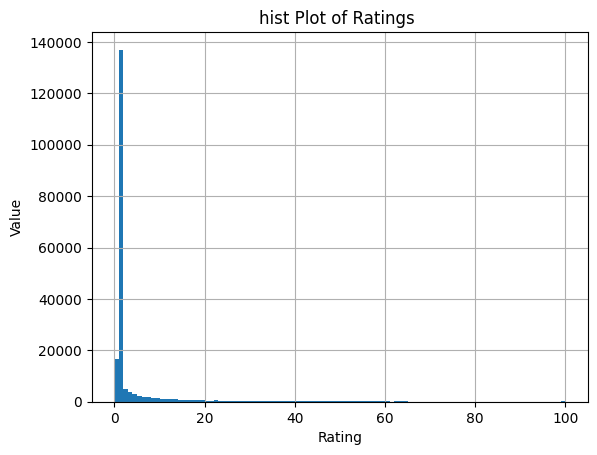

In [0]:
rate = StreamDf.select('Hours_played').toPandas()['Hours_played']

plt.hist(rate,bins = 100,range =(0,100))
plt.xlabel('Rating')
plt.ylabel('Value')
plt.grid('true')
plt.title('hist Plot of Ratings ')
plt.show()

In [0]:

quantiles = streamDF_format.approxQuantile('Hours_played', [0.25, 0.75], 0.05)
 
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1
 
# Define lower and upper bounds for outlier detection
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
 
# Filter out rows outside the lower and upper bounds
steam_play_without_outliers = streamDF_format.filter((col('Hours_played') >= lower_bound) & (col('Hours_played') <= upper_bound))
 
# Show the cleaned DataFrame
steam_play_without_outliers.show()

+---------+------------+-------+
|   UserID|Hours_played|game_ID|
+---------+------------+-------+
| 53875128|         9.8|    412|
| 53875128|         0.1|   1499|
| 65117175|         3.3|    997|
| 11373749|         7.0|   1997|
| 11373749|         2.3|   2686|
| 56038151|         2.8|   1129|
|100519466|         1.6|   4029|
|210669058|         1.4|      0|
|229467150|        24.0|      0|
|111316830|         6.0|   1187|
| 72842694|         1.7|   2221|
| 65229865|        22.0|   1020|
| 65958466|         7.1|   3671|
| 68224834|         4.8|   2609|
| 34177747|         0.3|   3674|
|196223620|        23.0|   1390|
|149438233|         0.2|   3893|
|118894547|         0.6|   1566|
| 87071236|         1.7|   3953|
|182399789|         0.2|    293|
+---------+------------+-------+
only showing top 20 rows



In [0]:
steam_play_without_outliers.count()

58750

#### TRAIN, TEST MODEL 

In [0]:
# Split the data into training and test sets (80% train, 20% test)
train_df, test_df = steam_play_without_outliers.randomSplit([0.8, 0.2], seed= 100)

train_df
test_df


DataFrame[UserID: int, Hours_played: double, game_ID: bigint]

In [0]:

# Initialize ALS model
als = ALS(maxIter=10, regParam=0.005, userCol="UserID", itemCol="game_ID", ratingCol="Hours_played", coldStartStrategy="drop")

# Train the ALS model
model = als.fit(train_df)

# Make predictions
predictions = model.transform(test_df)

predictions.show()

# Evaluate the model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_played", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))


2024/04/29 13:43:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '01158a921a0a4fdabfc8e081f8002717', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/29 13:43:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Valu

+------+------------+-------+-----------+
|UserID|Hours_played|game_ID| prediction|
+------+------------+-------+-----------+
| 76767|         0.4|    635|-0.41883755|
| 76767|        25.0|     44|  23.381395|
| 86540|         0.7|   1287|  1.1025791|
|181212|         1.8|   3689|  1.7994933|
|229911|         3.1|   2421|  3.0509377|
|298950|         0.1|   2133|  3.0305037|
|298950|         0.2|   1018|  2.8096833|
|298950|         0.2|   1329|   4.504989|
|298950|         0.2|   3078|   1.336753|
|298950|         0.2|   3869|  3.5374362|
|298950|         0.3|    793| 0.37601924|
|298950|         0.3|   2309|   1.572711|
|298950|         0.5|   3320|  3.1635754|
|298950|         0.8|   1252|  2.4779649|
|298950|         0.8|   1270|  1.0628536|
|298950|         0.9|   4288| -2.7471533|
|298950|         2.3|   3692|   3.073058|
|298950|         2.9|   2611|  2.4064314|
|298950|         5.4|   3200|  5.0817986|
|298950|        14.3|    739|   8.086756|
+------+------------+-------+-----

#### HYPERPARAMETER TUNING 

In [0]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit

als = ALS(maxIter=5, userCol="UserID", itemCol="game_ID", ratingCol="Hours_played", coldStartStrategy="drop", seed=100)
 

parameters = ParamGridBuilder()\
.addGrid(als.rank, [5, 10, 15])\
.addGrid(als.regParam, [0.001,0.01, 0.1, 0.05, 0.005, 0.5])\
.build()



In [0]:
tvs = TrainValidationSplit()\
.setSeed(100)\
.setTrainRatio(0.80)\
.setEstimatorParamMaps(parameters)\
.setEstimator(als)\
.setEvaluator(evaluator)



In [0]:
# Train model using grid search
gridsearchModel = tvs.fit(train_df)



2024/04/29 13:45:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '452fe4867b4649e1804f3d56b11558f8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/29 14:12:51 WARNING mlflow.pyspark.ml: Model TrainValidationSplitModel_b0e446f20942 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


In [0]:
# Select best model and identify the parameters
bestModel = gridsearchModel.bestModel
print("Parameters for the best model:")
print("Rank Parameter: %g" %bestModel.rank)
print("RegParam Parameter: %g" %bestModel._java_obj.parent().getRegParam())

# Evaluating the rmse using the best model
evaluator.evaluate(bestModel.transform(test_df))

Parameters for the best model:
Rank Parameter: 10
RegParam Parameter: 0.5


4.935390831859974

In [0]:

als = ALS(maxIter=10, regParam=0.5, userCol="UserID", itemCol="game_ID", ratingCol="Hours_played", coldStartStrategy="drop")

model = als.fit(train_df)

predictions = model.transform(test_df)

predictions.show()

# Evaluate the model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_played", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))

2024/04/29 14:12:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e40b224d55ef4c84bf62b410a4314091', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/29 14:14:09 WARNING mlflow.pyspark.ml: Model ALS_1368f5ea059a will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


+------+------------+-------+----------+
|UserID|Hours_played|game_ID|prediction|
+------+------------+-------+----------+
| 76767|         0.4|    635| 1.1622711|
| 76767|        25.0|     44| 20.028595|
| 86540|         0.7|   1287| 2.6321545|
|181212|         1.8|   3689| 1.6879678|
|229911|         3.1|   2421| 2.1289296|
|298950|         0.1|   2133|  1.715449|
|298950|         0.2|   1018| 2.9562411|
|298950|         0.2|   1329| 7.4517536|
|298950|         0.2|   3078|0.69751906|
|298950|         0.2|   3869|  9.369713|
|298950|         0.3|    793|0.21039894|
|298950|         0.3|   2309| 4.2675877|
|298950|         0.5|   3320| 6.0517826|
|298950|         0.8|   1252| 0.8991989|
|298950|         0.8|   1270|0.45009965|
|298950|         0.9|   4288| 5.9070597|
|298950|         2.3|   3692| 1.4294436|
|298950|         2.9|   2611| 2.4399023|
|298950|         5.4|   3200| 6.3771157|
|298950|        14.3|    739|  8.487346|
+------+------------+-------+----------+
only showing top